In [34]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import imageio
import tensorflow.compat.v1 as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [35]:
# Disable tensorflow v2 and reset default graph
tf.disable_v2_behavior()
tf.reset_default_graph()

In [36]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


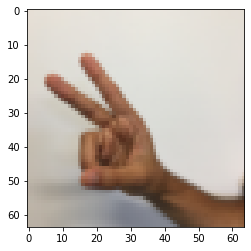

In [37]:
index = 6
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [38]:
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

In [39]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, (None, n_y))
    return X, Y

In [40]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.truncated_normal_initializer(stddev=0.1))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.1))
    parameters = {
        "W1": W1, "W2": W2
    }
    return parameters

In [41]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    F = tf.layers.flatten(P2)
    Z3 = tf.layers.dense(inputs=F, units=6 , activation=None)
    return Z3


In [42]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    return cost

In [43]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.009,
        num_epochs=100, minibatch_size=64, print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss=cost)
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, tempcost = sess.run(fetches=[optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += tempcost / num_minibatches

            if print_cost and epoch % 5 == 0:
                print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.title('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

    return train_accuracy, test_accuracy, parameters

Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 1.905962
Cost after epoch 5: 1.344159
Cost after epoch 10: 0.926890
Cost after epoch 15: 0.768662
Cost after epoch 20: 0.710830
Cost after epoch 25: 0.630928
Cost after epoch 30: 0.585870
Cost after epoch 35: 0.561010
Cost after epoch 40: 0.532321
Cost after epoch 45: 0.524823
Cost after epoch 50: 0.473464
Cost after epoch 55: 0.460194
Cost after epoch 60: 0.445127
Cost after epoch 65: 0.469598
Cost after epoch 70: 0.418692
Cost after epoch 75: 0.398497
Cost after epoch 80: 0.384030
Cost after epoch 85: 0.373588
Cost after epoch 90: 0.360609
Cost after epoch 95: 0.366199


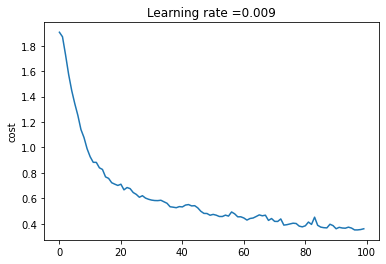

Train Accuracy: 0.88148147
Test Accuracy: 0.825


In [44]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)